In [1]:
import os
import urllib.request

# Create the directory if it doesn't exist
directory = '/content/data/bach-cello/'
os.makedirs(directory, exist_ok=True)

# List of URLs to download
urls = [
    "http://www.jsbach.net/midi/cs1-1pre.mid",
    "http://www.jsbach.net/midi/cs1-2all.mid",
    "http://www.jsbach.net/midi/cs1-3cou.mid",
    "http://www.jsbach.net/midi/cs1-4sar.mid",
    "http://www.jsbach.net/midi/cs1-5men.mid",
    "http://www.jsbach.net/midi/cs1-6gig.mid",
    "http://www.jsbach.net/midi/cs2-1pre.mid",
    "http://www.jsbach.net/midi/cs2-2all.mid",
    "http://www.jsbach.net/midi/cs2-3cou.mid",
    "http://www.jsbach.net/midi/cs2-4sar.mid",
    "http://www.jsbach.net/midi/cs2-5men.mid",
    "http://www.jsbach.net/midi/cs2-6gig.mid",
    "http://www.jsbach.net/midi/cs3-1pre.mid",
    "http://www.jsbach.net/midi/cs3-2all.mid",
    "http://www.jsbach.net/midi/cs3-3cou.mid",
    "http://www.jsbach.net/midi/cs3-4sar.mid",
    "http://www.jsbach.net/midi/cs3-5bou.mid",
    "http://www.jsbach.net/midi/cs3-6gig.mid",
    "http://www.jsbach.net/midi/cs4-1pre.mid",
    "http://www.jsbach.net/midi/cs4-2all.mid",
    "http://www.jsbach.net/midi/cs4-3cou.mid",
    "http://www.jsbach.net/midi/cs4-4sar.mid",
    "http://www.jsbach.net/midi/cs4-5bou.mid",
    "http://www.jsbach.net/midi/cs4-6gig.mid",
    "http://www.jsbach.net/midi/cs5-1pre.mid",
    "http://www.jsbach.net/midi/cs5-2all.mid",
    "http://www.jsbach.net/midi/cs5-3cou.mid",
    "http://www.jsbach.net/midi/cs5-4sar.mid",
    "http://www.jsbach.net/midi/cs5-5gav.mid",
    "http://www.jsbach.net/midi/cs5-6gig.mid",
    "http://www.jsbach.net/midi/cs6-1pre.mid",
    "http://www.jsbach.net/midi/cs6-2all.mid",
    "http://www.jsbach.net/midi/cs6-3cou.mid",
    "http://www.jsbach.net/midi/cs6-4sar.mid",
    "http://www.jsbach.net/midi/cs6-5gav.mid",
    "http://www.jsbach.net/midi/cs6-6gig.mid"
]

# Download each file
for url in urls:
    filename = os.path.join(directory, os.path.basename(url))
    print("Downloading", filename)
    urllib.request.urlretrieve(url, filename)

print('🚀 Done!')


🚀 Done!


In [2]:
!mkdir -p /content/data/bach-chorales/
!cd /content/data/bach-chorales/ && \
echo 'Downloading...' && \
wget -q https://github.com/czhuang/JSB-Chorales-dataset/raw/master/Jsb16thSeparated.npz && \
echo '🚀 Done!'


Downloading...
🚀 Done!


In [3]:
%load_ext autoreload
%autoreload 2

import os
import glob
import numpy as np
import time
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models, losses, callbacks

import music21 # We’ll be using the Python library music21 to load the MIDI files into Python for processing

In [4]:
import os
import pickle as pkl
import music21
import keras
import tensorflow as tf

from fractions import Fraction


def parse_midi_files(file_list, parser, seq_len, parsed_data_path=None):
    notes_list = []
    duration_list = []
    notes = []
    durations = []

    for i, file in enumerate(file_list):
        print(i + 1, "Parsing %s" % file)
        score = parser.parse(file).chordify()

        notes.append("START")
        durations.append("0.0")

        for element in score.flat:
            note_name = None
            duration_name = None

            if isinstance(element, music21.key.Key):
                note_name = str(element.tonic.name) + ":" + str(element.mode)
                duration_name = "0.0"

            elif isinstance(element, music21.meter.TimeSignature):
                note_name = str(element.ratioString) + "TS"
                duration_name = "0.0"

            elif isinstance(element, music21.chord.Chord):
                note_name = element.pitches[-1].nameWithOctave
                duration_name = str(element.duration.quarterLength)

            elif isinstance(element, music21.note.Rest):
                note_name = str(element.name)
                duration_name = str(element.duration.quarterLength)

            elif isinstance(element, music21.note.Note):
                note_name = str(element.nameWithOctave)
                duration_name = str(element.duration.quarterLength)

            if note_name and duration_name:
                notes.append(note_name)
                durations.append(duration_name)
        print(f"{len(notes)} notes parsed")

    notes_list = []
    duration_list = []

    print(f"Building sequences of length {seq_len}")
    for i in range(len(notes) - seq_len):
        notes_list.append(" ".join(notes[i : (i + seq_len)]))
        duration_list.append(" ".join(durations[i : (i + seq_len)]))

    if parsed_data_path:
        with open(os.path.join(parsed_data_path, "notes"), "wb") as f:
            pkl.dump(notes_list, f)
        with open(os.path.join(parsed_data_path, "durations"), "wb") as f:
            pkl.dump(duration_list, f)

    return notes_list, duration_list


def load_parsed_files(parsed_data_path):
    with open(os.path.join(parsed_data_path, "notes"), "rb") as f:
        notes = pkl.load(f)
    with open(os.path.join(parsed_data_path, "durations"), "rb") as f:
        durations = pkl.load(f)
    return notes, durations


def get_midi_note(sample_note, sample_duration):
    new_note = None

    if "TS" in sample_note:
        new_note = music21.meter.TimeSignature(sample_note.split("TS")[0])

    elif "major" in sample_note or "minor" in sample_note:
        tonic, mode = sample_note.split(":")
        new_note = music21.key.Key(tonic, mode)

    elif sample_note == "rest":
        new_note = music21.note.Rest()
        new_note.duration = music21.duration.Duration(
            float(Fraction(sample_duration))
        )
        new_note.storedInstrument = music21.instrument.Violoncello()

    elif "." in sample_note:
        notes_in_chord = sample_note.split(".")
        chord_notes = []
        for current_note in notes_in_chord:
            n = music21.note.Note(current_note)
            n.duration = music21.duration.Duration(
                float(Fraction(sample_duration))
            )
            n.storedInstrument = music21.instrument.Violoncello()
            chord_notes.append(n)
        new_note = music21.chord.Chord(chord_notes)

    elif sample_note == "rest":
        new_note = music21.note.Rest()
        new_note.duration = music21.duration.Duration(
            float(Fraction(sample_duration))
        )
        new_note.storedInstrument = music21.instrument.Violoncello()

    elif sample_note != "START":
        new_note = music21.note.Note(sample_note)
        new_note.duration = music21.duration.Duration(
            float(Fraction(sample_duration))
        )
        new_note.storedInstrument = music21.instrument.Violoncello()

    return new_note


class SinePositionEncoding(keras.layers.Layer):
    """Sinusoidal positional encoding layer.
    This layer calculates the position encoding as a mix of sine and cosine
    functions with geometrically increasing wavelengths. Defined and formulized
    in [Attention is All You Need](https://arxiv.org/abs/1706.03762).
    Takes as input an embedded token tensor. The input must have shape
    [batch_size, sequence_length, feature_size]. This layer will return a
    positional encoding the same size as the embedded token tensor, which
    can be added directly to the embedded token tensor.
    Args:
        max_wavelength: The maximum angular wavelength of the sine/cosine
            curves, as described in Attention is All You Need. Defaults to
            10000.
    Examples:
    ```python
    # create a simple embedding layer with sinusoidal positional encoding
    seq_len = 100
    vocab_size = 1000
    embedding_dim = 32
    inputs = keras.Input((seq_len,), dtype=tf.float32)
    embedding = keras.layers.Embedding(
        input_dim=vocab_size, output_dim=embedding_dim
    )(inputs)
    positional_encoding = keras_nlp.layers.SinePositionEncoding()(embedding)
    outputs = embedding + positional_encoding
    ```
    References:
     - [Vaswani et al., 2017](https://arxiv.org/abs/1706.03762)
    """

    def __init__(
        self,
        max_wavelength=10000,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.max_wavelength = max_wavelength

    def call(self, inputs):
        # TODO(jbischof): replace `hidden_size` with`hidden_dim` for consistency
        # with other layers.
        input_shape = tf.shape(inputs)
        # length of sequence is the second last dimension of the inputs
        seq_length = input_shape[-2]
        hidden_size = input_shape[-1]
        position = tf.cast(tf.range(seq_length), self.compute_dtype)
        min_freq = tf.cast(1 / self.max_wavelength, dtype=self.compute_dtype)
        timescales = tf.pow(
            min_freq,
            tf.cast(2 * (tf.range(hidden_size) // 2), self.compute_dtype)
            / tf.cast(hidden_size, self.compute_dtype),
        )
        angles = tf.expand_dims(position, 1) * tf.expand_dims(timescales, 0)
        # even indices are sine, odd are cosine
        cos_mask = tf.cast(tf.range(hidden_size) % 2, self.compute_dtype)
        sin_mask = 1 - cos_mask
        # embedding shape is [seq_length, hidden_size]
        positional_encodings = (
            tf.sin(angles) * sin_mask + tf.cos(angles) * cos_mask
        )

        return tf.broadcast_to(positional_encodings, input_shape)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "max_wavelength": self.max_wavelength,
            }
        )
        return config

In [5]:
PARSE_MIDI_FILES = True
PARSED_DATA_PATH = "/content/data"
DATASET_REPETITIONS = 1

SEQ_LEN = 50
EMBEDDING_DIM = 256
KEY_DIM = 256
N_HEADS = 5
DROPOUT_RATE = 0.
FEED_FORWARD_DIM = 256
LOAD_MODEL = False

# optimization
EPOCHS = 5000
BATCH_SIZE = 256

GENERATE_LEN = 50

In [6]:
# Load the data
file_list = glob.glob("/content/data/bach-cello/*.mid")
print(f"Found {len(file_list)} midi files")

Found 36 midi files


In [7]:
parser = music21.converter

In [8]:
example_score = (
    music21.converter.parse(file_list[1]).splitAtQuarterLength(12)[0].chordify()
)

In [9]:
example_score.show("text")

{0.0} <music21.metadata.Metadata object at 0x7e3f29aec520>
{0.0} <music21.stream.Measure 1 offset=0.0>
    {0.0} <music21.instrument.Violoncello 'Solo Cello: Solo Cello'>
    {0.0} <music21.instrument.Violoncello 'Violoncello'>
    {0.0} <music21.clef.BassClef>
    {0.0} <music21.tempo.MetronomeMark Quarter=250>
    {0.0} <music21.key.Key of G major>
    {0.0} <music21.meter.TimeSignature 4/4>
    {0.0} <music21.note.Rest 3.75ql>
    {3.5} <music21.tempo.MetronomeMark Quarter=77>
    {3.75} <music21.chord.Chord B3>
{4.0} <music21.stream.Measure 2 offset=4.0>
    {0.0} <music21.chord.Chord G2 D3 B3>
    {1.0} <music21.chord.Chord B3>
    {1.25} <music21.chord.Chord A3>
    {1.5} <music21.chord.Chord G3>
    {1.75} <music21.chord.Chord F#3>
    {2.0} <music21.chord.Chord G3>
    {2.25} <music21.chord.Chord D3>
    {2.5} <music21.chord.Chord E3>
    {2.75} <music21.chord.Chord F#3>
    {3.0} <music21.chord.Chord G3>
    {3.25} <music21.chord.Chord A3>
    {3.5} <music21.chord.Chord B3>
  

Now it’s time to convert the scores into something that looks more like text! We start
by looping over each score and extracting the note and duration of each element in
the piece into two separate text strings, with elements separated by spaces. We encode
the key and time signature of the piece as special symbols, with zero duration.

In this first example, we will treat the music as monophonic (one
single line), taking just the top note of any chords. Sometimes we
may wish to keep the parts separate to generate music that is poly‐
phonic in nature.

In [10]:
if PARSE_MIDI_FILES:
    notes, durations = parse_midi_files(
        file_list, parser, SEQ_LEN + 1, PARSED_DATA_PATH
    )
else:
    notes, durations = load_parsed_files()

1 Parsing /content/data/bach-cello/cs1-5men.mid


<ipython-input-10-04172d0f16ff>:2: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  notes, durations = parse_midi_files(


647 notes parsed
2 Parsing /content/data/bach-cello/cs1-2all.mid
1568 notes parsed
3 Parsing /content/data/bach-cello/cs3-2all.mid
2305 notes parsed
4 Parsing /content/data/bach-cello/cs2-6gig.mid
3040 notes parsed
5 Parsing /content/data/bach-cello/cs5-1pre.mid
4349 notes parsed
6 Parsing /content/data/bach-cello/cs1-4sar.mid
4612 notes parsed
7 Parsing /content/data/bach-cello/cs1-6gig.mid
5038 notes parsed
8 Parsing /content/data/bach-cello/cs4-5bou.mid
6362 notes parsed
9 Parsing /content/data/bach-cello/cs3-1pre.mid
7343 notes parsed
10 Parsing /content/data/bach-cello/cs3-5bou.mid
8224 notes parsed
11 Parsing /content/data/bach-cello/cs5-2all.mid
8916 notes parsed
12 Parsing /content/data/bach-cello/cs4-2all.mid
9971 notes parsed
13 Parsing /content/data/bach-cello/cs2-5men.mid
10498 notes parsed
14 Parsing /content/data/bach-cello/cs5-6gig.mid
10947 notes parsed
15 Parsing /content/data/bach-cello/cs3-4sar.mid
11288 notes parsed
16 Parsing /content/data/bach-cello/cs1-1pre.mid
1

In [11]:
example_notes = notes[658]
example_durations = durations[658]
print("\nNotes string\n", example_notes, "...")
print("\nDuration string\n", example_durations, "...")


Notes string
 D3 E3 F#3 G3 A3 B3 C4 D4 B3 G3 F#3 G3 E3 D3 C3 B2 C3 D3 E3 F#3 G3 A3 B3 C4 A3 G3 F#3 G3 E3 F#3 G3 A2 D3 F#3 G3 A3 B3 C4 A3 B3 G3 G3 D3 D3 B2 B2 G2 G2 B3 C4 B3 ...

Duration string
 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.75 0.25 0.25 0.25 ...


This looks a lot more like the text data that we have dealt with previously. The words
are the note–duration combinations, and we should try to build a model that predicts
the next note and duration, given a sequence of previous notes and durations. A key
difference between music and text generation is that we need to build a model that
can handle the note and duration prediction simultaneously—i.e., there are two
streams of information that we need to handle,

# Tokenize the data

To create the dataset that will train the model, we first need to tokenize each note and
duration, exactly as we did previously for each word in a text corpus. We can achieve
this by using a TextVectorization layer, applied to the notes and durations sepa‐
rately

In [12]:
def create_dataset(elements):
    ds = (
        tf.data.Dataset.from_tensor_slices(elements)
        .batch(BATCH_SIZE, drop_remainder=True)
        .shuffle(1000)
    )
    vectorize_layer = layers.TextVectorization(
        standardize=None, output_mode="int"
    )
    vectorize_layer.adapt(ds)
    vocab = vectorize_layer.get_vocabulary()
    return ds, vectorize_layer, vocab


notes_seq_ds, notes_vectorize_layer, notes_vocab = create_dataset(notes)
durations_seq_ds, durations_vectorize_layer, durations_vocab = create_dataset(
    durations
)
seq_ds = tf.data.Dataset.zip((notes_seq_ds, durations_seq_ds))

In [13]:
# Display the same example notes and durations converted to ints
example_tokenised_notes = notes_vectorize_layer(example_notes)
example_tokenised_durations = durations_vectorize_layer(example_durations)
print("{:10} {:10}".format("note token", "duration token"))
for i, (note_int, duration_int) in enumerate(
    zip(
        example_tokenised_notes.numpy()[:11],
        example_tokenised_durations.numpy()[:11],
    )
):
    print(f"{note_int:10}{duration_int:10}")

note token duration token
         3         2
         8         2
        12         2
         2         2
         4         2
         9         2
         6         2
         7         2
         9         2
         2         2
        12         2


In [14]:
notes_vocab_size = len(notes_vocab)
durations_vocab_size = len(durations_vocab)

# Display some token:note mappings
print(f"\nNOTES_VOCAB: length = {len(notes_vocab)}")
for i, note in enumerate(notes_vocab[:10]):
    print(f"{i}: {note}")

print(f"\nDURATIONS_VOCAB: length = {len(durations_vocab)}")
# Display some token:duration mappings
for i, note in enumerate(durations_vocab[:10]):
    print(f"{i}: {note}")


NOTES_VOCAB: length = 59
0: 
1: [UNK]
2: G3
3: D3
4: A3
5: F3
6: C4
7: D4
8: E3
9: B3

DURATIONS_VOCAB: length = 24
0: 
1: [UNK]
2: 0.25
3: 0.5
4: 1.0
5: 1/3
6: 0.75
7: 1/12
8: 1.5
9: 0.0


The final step of preprocessing is to create the training set that we will feed to our
Transformer.


We do this by splitting both the note and duration strings into chunks of 50 elements,
using a sliding window technique. The output is simply the input window shifted by
one note, so that the Transformer is trained to predict the note and duration of the
element one timestep into the future, given previous elements in the window.

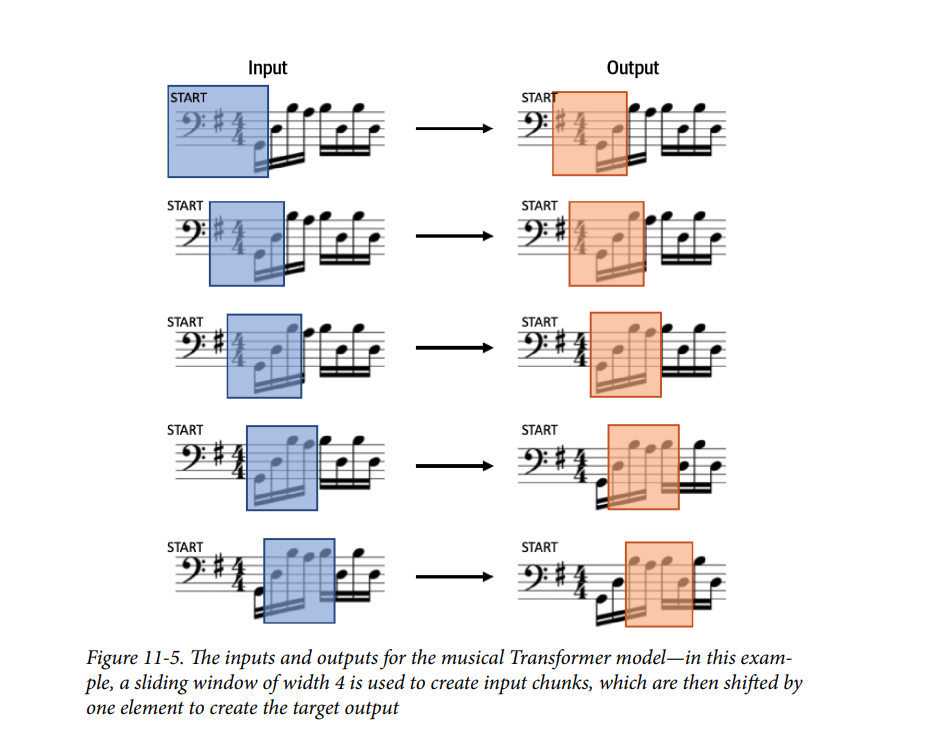

In [15]:
# Create the training set of sequences and the same sequences shifted by one note
def prepare_inputs(notes, durations):
    notes = tf.expand_dims(notes, -1)
    durations = tf.expand_dims(durations, -1)
    tokenized_notes = notes_vectorize_layer(notes)
    tokenized_durations = durations_vectorize_layer(durations)
    x = (tokenized_notes[:, :-1], tokenized_durations[:, :-1])
    y = (tokenized_notes[:, 1:], tokenized_durations[:, 1:])
    return x, y


ds = seq_ds.map(prepare_inputs).repeat(DATASET_REPETITIONS)

In [16]:
example_input_output = ds.take(1).get_single_element()
print(example_input_output)

((<tf.Tensor: shape=(256, 50), dtype=int64, numpy=
array([[ 2,  2,  9, ..., 25,  8, 12],
       [ 2,  9,  7, ...,  8, 12,  9],
       [ 9,  7,  7, ..., 12,  9, 12],
       ...,
       [12,  4, 17, ...,  2,  8, 25],
       [ 4, 17,  7, ...,  8, 25,  4],
       [17,  7, 17, ..., 25,  4, 15]])>, <tf.Tensor: shape=(256, 50), dtype=int64, numpy=
array([[4, 8, 3, ..., 2, 2, 2],
       [8, 3, 2, ..., 2, 2, 2],
       [3, 2, 2, ..., 2, 2, 2],
       ...,
       [2, 2, 2, ..., 3, 3, 3],
       [2, 2, 2, ..., 3, 3, 3],
       [2, 2, 2, ..., 3, 3, 3]])>), (<tf.Tensor: shape=(256, 50), dtype=int64, numpy=
array([[ 2,  9,  7, ...,  8, 12,  9],
       [ 9,  7,  7, ..., 12,  9, 12],
       [ 7,  7,  7, ...,  9, 12,  4],
       ...,
       [ 4, 17,  7, ...,  8, 25,  4],
       [17,  7, 17, ..., 25,  4, 15],
       [ 7, 17,  7, ...,  4, 15, 23]])>, <tf.Tensor: shape=(256, 50), dtype=int64, numpy=
array([[8, 3, 2, ..., 2, 2, 2],
       [3, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       ...,

In [17]:
def causal_attention_mask(batch_size, n_dest, n_src, dtype):
    i = tf.range(n_dest)[:, None]
    j = tf.range(n_src)
    m = i >= j - n_src + n_dest
    mask = tf.cast(m, dtype)
    mask = tf.reshape(mask, [1, n_dest, n_src])
    mult = tf.concat(
        [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)], 0
    )
    return tf.tile(mask, mult)


np.transpose(causal_attention_mask(1, 10, 10, dtype=tf.int32)[0])

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]], dtype=int32)

The architecture we will be using for our Transformer is the same as we used for text
generation

In [18]:
class TransformerBlock(layers.Layer):
    def __init__(
        self,
        num_heads,
        key_dim,
        embed_dim,
        ff_dim,
        name,
        dropout_rate=DROPOUT_RATE,
    ):
        super(TransformerBlock, self).__init__(name=name)
        self.num_heads = num_heads
        self.key_dim = key_dim
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.dropout_rate = dropout_rate
        self.attn = layers.MultiHeadAttention(
            num_heads, key_dim, output_shape=embed_dim
        )
        self.dropout_1 = layers.Dropout(self.dropout_rate)
        self.ln_1 = layers.LayerNormalization(epsilon=1e-6)
        self.ffn_1 = layers.Dense(self.ff_dim, activation="relu")
        self.ffn_2 = layers.Dense(self.embed_dim)
        self.dropout_2 = layers.Dropout(self.dropout_rate)
        self.ln_2 = layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size = input_shape[0]
        seq_len = input_shape[1]
        causal_mask = causal_attention_mask(
            batch_size, seq_len, seq_len, tf.bool
        )
        attention_output, attention_scores = self.attn(
            inputs,
            inputs,
            attention_mask=causal_mask,
            return_attention_scores=True,
        )
        attention_output = self.dropout_1(attention_output)
        out1 = self.ln_1(inputs + attention_output)
        ffn_1 = self.ffn_1(out1)
        ffn_2 = self.ffn_2(ffn_1)
        ffn_output = self.dropout_2(ffn_2)
        return (self.ln_2(out1 + ffn_output), attention_scores)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "key_dim": self.key_dim,
                "embed_dim": self.embed_dim,
                "num_heads": self.num_heads,
                "ff_dim": self.ff_dim,
                "dropout_rate": self.dropout_rate,
            }
        )
        return config

# SIne Position Encoding

 Sine position embedding is similar to the embedding that we used in
 to encode the noise variances of the diffusion model. Specifically, the following function is used to convert the position of the word (pos) in the input
sequence into a unique vector of length d:

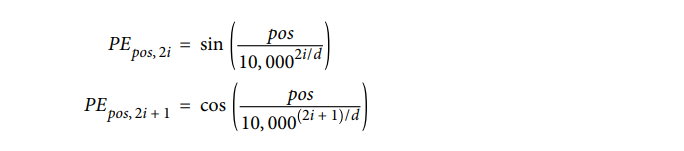

For small i, the wavelength of this function is short and therefore the function value
changes rapidly along the position axis. Larger values of i create a longer wavelength.
Each position thus has its own unique encoding, which is a specific combination of
the different wavelengths.

Notice that this embedding is defined for all possible position values. It is a deterministic function (i.e., it isn’t learned by the model)
that uses trigonometric functions to define a unique encoding for
each possible position.

In [19]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.token_emb = layers.Embedding(
            input_dim=vocab_size,
            output_dim=embed_dim,
            embeddings_initializer="he_uniform",
        )
        self.pos_emb = SinePositionEncoding()

    def call(self, x):
        embedding = self.token_emb(x)
        positions = self.pos_emb(embedding)
        return embedding + positions

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "vocab_size": self.vocab_size,
                "embed_dim": self.embed_dim,
            }
        )
        return config

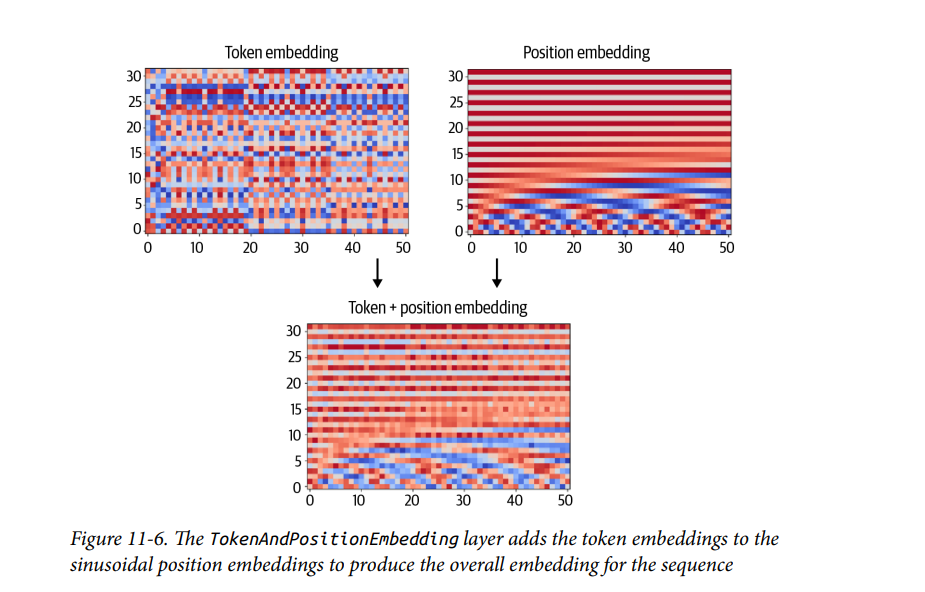

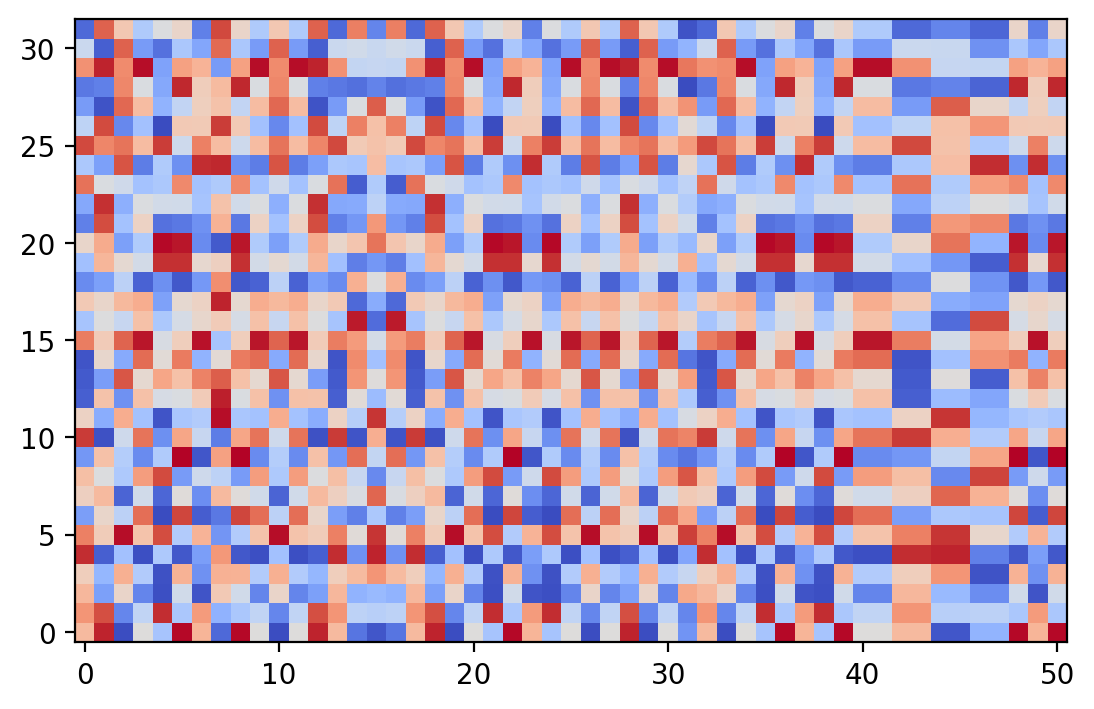

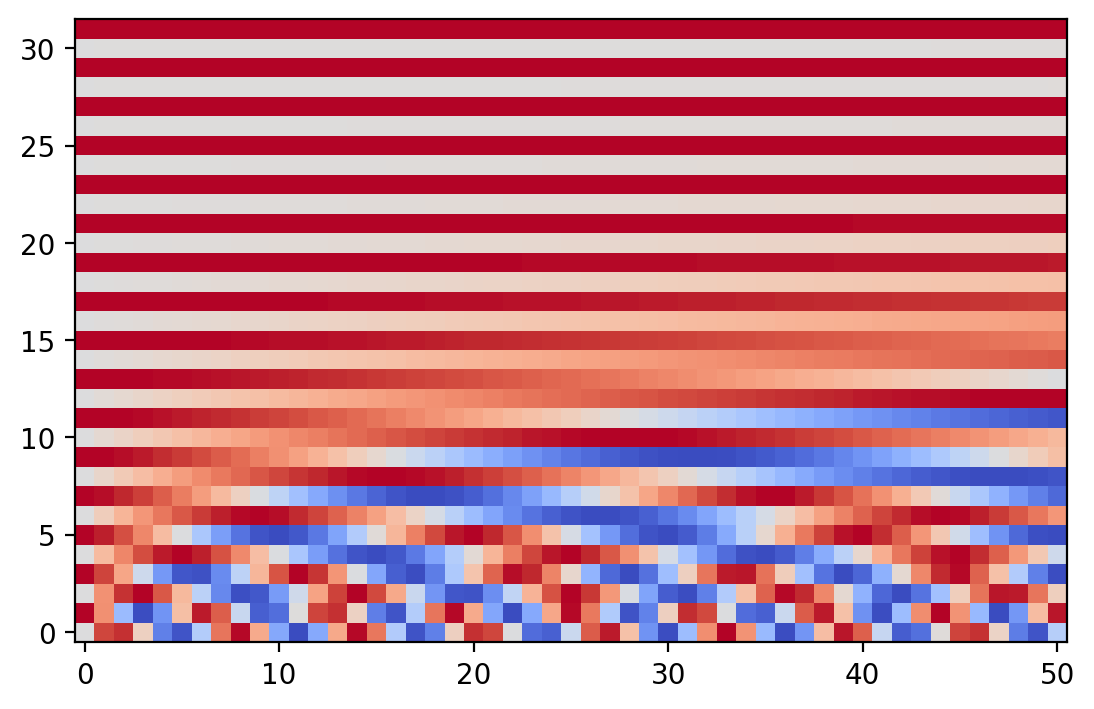

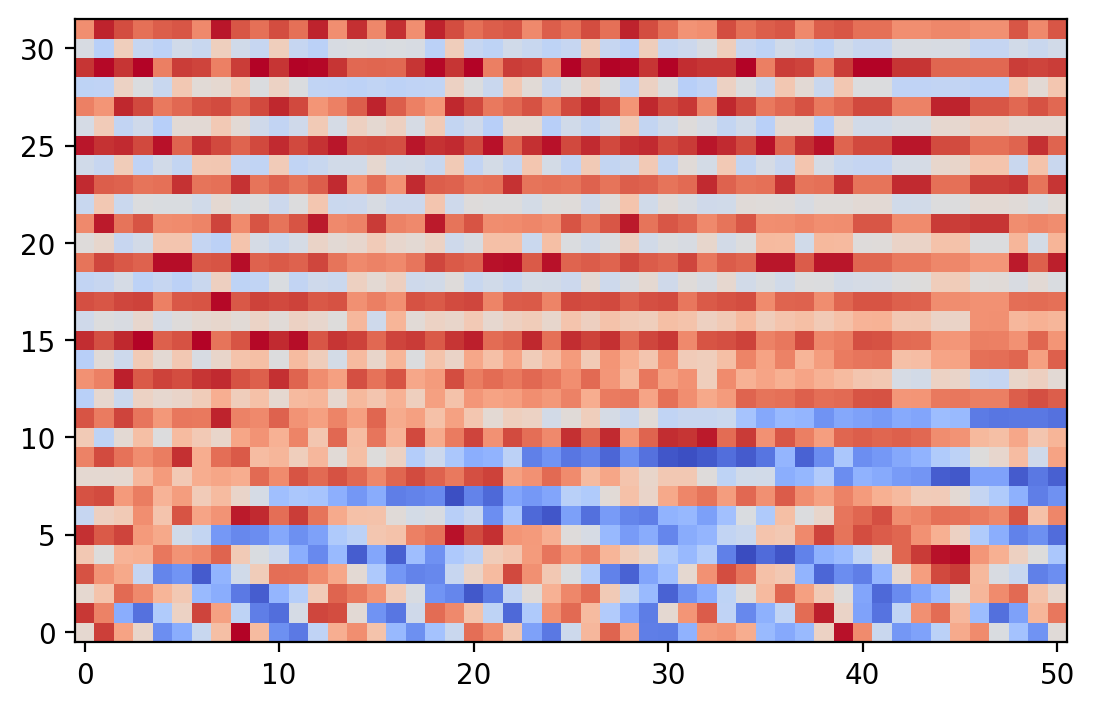

In [20]:
tpe = TokenAndPositionEmbedding(notes_vocab_size, 32)
token_embedding = tpe.token_emb(example_tokenised_notes)
position_embedding = tpe.pos_emb(token_embedding)
embedding = tpe(example_tokenised_notes)
plt.imshow(
    np.transpose(token_embedding),
    cmap="coolwarm",
    interpolation="nearest",
    origin="lower",
)
plt.show()
plt.imshow(
    np.transpose(position_embedding),
    cmap="coolwarm",
    interpolation="nearest",
    origin="lower",
)
plt.show()
plt.imshow(
    np.transpose(embedding),
    cmap="coolwarm",
    interpolation="nearest",
    origin="lower",
)
plt.show()

We now have two input streams (notes and durations) and two output streams (pre‐
dicted notes and durations). We therefore need to adapt the architecture of our
Transformer to cater for this.

We choose to embed the note and duration tokens separately and then use a
concatenation layer to create a single representation of the input that can be used by
the downstream Transformer block. Similarly, the output from the Transformer block
is passed to two separate dense layers, which represent the predicted note and duration probabilities.

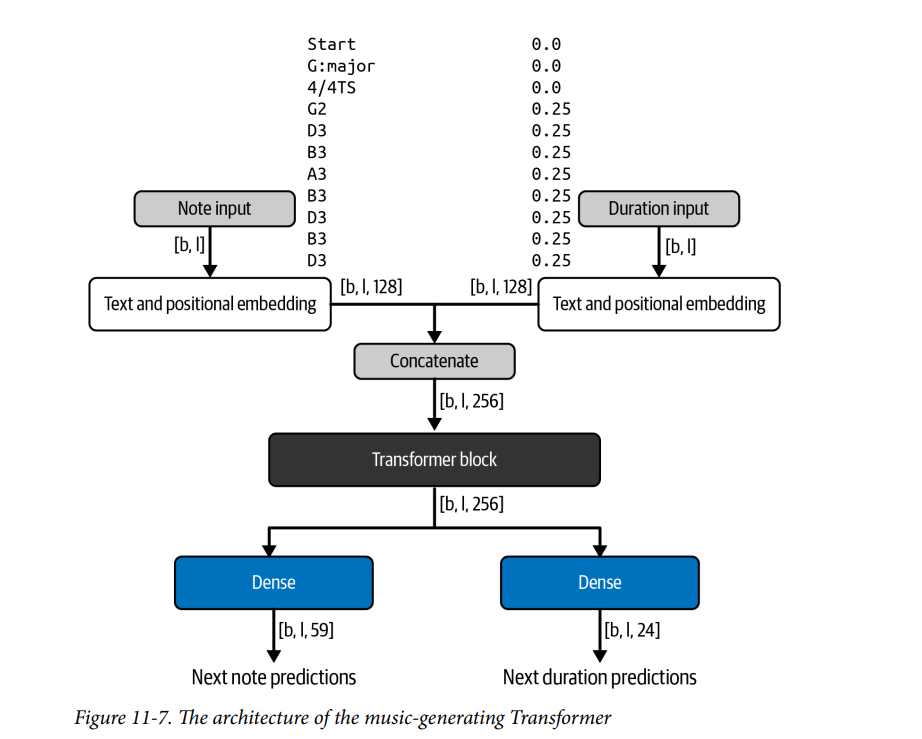

In [21]:
note_inputs = layers.Input(shape=(None,), dtype=tf.int32)
durations_inputs = layers.Input(shape=(None,), dtype=tf.int32)
note_embeddings = TokenAndPositionEmbedding(
    notes_vocab_size, EMBEDDING_DIM // 2
)(note_inputs)
duration_embeddings = TokenAndPositionEmbedding(
    durations_vocab_size, EMBEDDING_DIM // 2
)(durations_inputs)
embeddings = layers.Concatenate()([note_embeddings, duration_embeddings])
x, attention_scores = TransformerBlock(
    N_HEADS, KEY_DIM, EMBEDDING_DIM, FEED_FORWARD_DIM, name="attention"
)(embeddings)
note_outputs = layers.Dense(
    notes_vocab_size, activation="softmax", name="note_outputs"
)(x)
duration_outputs = layers.Dense(
    durations_vocab_size, activation="softmax", name="duration_outputs"
)(x)
model = models.Model(
    inputs=[note_inputs, durations_inputs],
    outputs=[note_outputs, duration_outputs],  # attention_scores
)
model.compile(
    "adam",
    loss=[
        losses.SparseCategoricalCrossentropy(),
        losses.SparseCategoricalCrossentropy(),
    ],
)
att_model = models.Model(
    inputs=[note_inputs, durations_inputs], outputs=attention_scores
)

In [22]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 token_and_position_embeddi  (None, None, 128)            7552      ['input_1[0][0]']             
 ng_1 (TokenAndPositionEmbe                                                                       
 dding)                                                                                           
                                                                                              

In [23]:
# Create a MusicGenerator checkpoint
class MusicGenerator(callbacks.Callback):
    def __init__(self, index_to_note, index_to_duration, top_k=10):
        self.index_to_note = index_to_note
        self.note_to_index = {
            note: index for index, note in enumerate(index_to_note)
        }
        self.index_to_duration = index_to_duration
        self.duration_to_index = {
            duration: index for index, duration in enumerate(index_to_duration)
        }

    def sample_from(self, probs, temperature):
        probs = probs ** (1 / temperature)
        probs = probs / np.sum(probs)
        return np.random.choice(len(probs), p=probs), probs

    def get_note(self, notes, durations, temperature):
        sample_note_idx = 1
        while sample_note_idx == 1:
            sample_note_idx, note_probs = self.sample_from(
                notes[0][-1], temperature
            )
            sample_note = self.index_to_note[sample_note_idx]

        sample_duration_idx = 1
        while sample_duration_idx == 1:
            sample_duration_idx, duration_probs = self.sample_from(
                durations[0][-1], temperature
            )
            sample_duration = self.index_to_duration[sample_duration_idx]

        new_note = get_midi_note(sample_note, sample_duration)

        return (
            new_note,
            sample_note_idx,
            sample_note,
            note_probs,
            sample_duration_idx,
            sample_duration,
            duration_probs,
        )

    def generate(self, start_notes, start_durations, max_tokens, temperature):
        attention_model = models.Model(
            inputs=self.model.input,
            outputs=self.model.get_layer("attention").output,
        )

        start_note_tokens = [self.note_to_index.get(x, 1) for x in start_notes]
        start_duration_tokens = [
            self.duration_to_index.get(x, 1) for x in start_durations
        ]
        sample_note = None
        sample_duration = None
        info = []
        midi_stream = music21.stream.Stream()

        midi_stream.append(music21.clef.BassClef())

        for sample_note, sample_duration in zip(start_notes, start_durations):
            new_note = get_midi_note(sample_note, sample_duration)
            if new_note is not None:
                midi_stream.append(new_note)

        while len(start_note_tokens) < max_tokens:
            x1 = np.array([start_note_tokens])
            x2 = np.array([start_duration_tokens])
            notes, durations = self.model.predict([x1, x2], verbose=0)

            repeat = True

            while repeat:
                (
                    new_note,
                    sample_note_idx,
                    sample_note,
                    note_probs,
                    sample_duration_idx,
                    sample_duration,
                    duration_probs,
                ) = self.get_note(notes, durations, temperature)

                if (
                    isinstance(new_note, music21.chord.Chord)
                    or isinstance(new_note, music21.note.Note)
                    or isinstance(new_note, music21.note.Rest)
                ) and sample_duration == "0.0":
                    repeat = True
                else:
                    repeat = False

            if new_note is not None:
                midi_stream.append(new_note)

            _, att = attention_model.predict([x1, x2], verbose=0)

            info.append(
                {
                    "prompt": [start_notes.copy(), start_durations.copy()],
                    "midi": midi_stream,
                    "chosen_note": (sample_note, sample_duration),
                    "note_probs": note_probs,
                    "duration_probs": duration_probs,
                    "atts": att[0, :, -1, :],
                }
            )
            start_note_tokens.append(sample_note_idx)
            start_duration_tokens.append(sample_duration_idx)
            start_notes.append(sample_note)
            start_durations.append(sample_duration)

            if sample_note == "START":
                break

        return info

    def on_epoch_end(self, epoch, logs=None):
        info = self.generate(
            ["START"], ["0.0"], max_tokens=GENERATE_LEN, temperature=0.5
        )
        midi_stream = info[-1]["midi"].chordify()
        print(info[-1]["prompt"])
        midi_stream.write(
            "midi",
            fp=os.path.join(
                "/content/output",
                "output-" + str(epoch).zfill(4) + ".mid",
            ),
        )

In [24]:
# Tokenize starting prompt
music_generator = MusicGenerator(notes_vocab, durations_vocab)

In [25]:
model.fit(
    ds,
    epochs=EPOCHS,
    callbacks=[
        music_generator,
    ],
)

Epoch 1/5000
107/107 [==============================] - 23s 163ms/step - loss: 4.5919 - note_outputs_loss: 3.3229 - duration_outputs_loss: 1.2690
Epoch 2/5000
107/107 [==============================] - 14s 128ms/step - loss: 3.9242 - note_outputs_loss: 3.1833 - duration_outputs_loss: 0.7409
Epoch 3/5000
107/107 [==============================] - 17s 155ms/step - loss: 3.5163 - note_outputs_loss: 2.8519 - duration_outputs_loss: 0.6644
Epoch 4/5000
107/107 [==============================] - 19s 178ms/step - loss: 3.3545 - note_outputs_loss: 2.6627 - duration_outputs_loss: 0.6918
Epoch 5/5000
107/107 [==============================] - 14s 127ms/step - loss: 3.2027 - note_outputs_loss: 2.5723 - duration_outputs_loss: 0.6304
Epoch 6/5000
107/107 [==============================] - 13s 122ms/step - loss: 3.1092 - note_outputs_loss: 2.4975 - duration_outputs_loss: 0.6117
Epoch 7/5000
107/107 [==============================] - 14s 128ms/step - loss: 3.0622 - note_outputs_loss: 2.4699 - duration

[['START', '4/4TS', '4/4TS', '4/4TS', 'F3', 'E-3', 'D3', 'C3', 'B2', 'C3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'A3', 'B-3', 'C4', 'B-3', 'A3', 'G3', 'F3', 'F3', 'E-3', 'D3', 'F3', 'E-3', 'D3', 'C3', 'D3', 'E-3', 'G2', 'E2', 'D2', 'D3', 'B-2', 'C3', 'D3', 'E-3', 'F3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'G3', 'F3'], ['0.0', '0.0', '0.0', '0.0', '3.75', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]
107/107 [==============================] - 14s 130ms/step - loss: 2.7542 - note_outputs_loss: 2.2089 - duration_outputs_loss: 0.5452
Epoch 19/5000
107/107 [==============================] - 13s 124ms/step - loss: 2.7590 - note_outputs_loss: 2.1973 - duration_outputs_loss: 0.5617
Epoch 20

[['START', 'E-:major', '3/8TS', 'rest', 'E-3', 'E-3', 'D3', 'E-3', 'F3', 'G#3', 'G#3', 'G#3', 'F3', 'E-3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'G#3', 'E-3', 'F3', 'D3', 'E-3', 'F3', 'G#3', 'G#3', 'F3', 'G3', 'E-3', 'F3', 'D3', 'E-3', 'F3', 'D3', 'E-3', 'F3', 'G#3', 'G#3', 'B-3', 'G3', 'G#3', 'F3', 'E-3', 'G#3', 'F3', 'G3', 'G#3', 'B-3'], ['0.0', '0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]
107/107 [==============================] - 14s 126ms/step - loss: 2.6154 - note_outputs_loss: 2.0694 - duration_outputs_loss: 0.5460
Epoch 28/5000
107/107 [==============================] - 8s 76ms/step - loss: 2.6150 - note_outputs_loss: 2.0708 - duration_outputs_loss: 0.5442
Epoch 29/5000
107/107 [==================

KeyboardInterrupt: 

# Generate music using the Transformer

We’ll start by generating some music from scratch, by seeding the network with a
START note token and 0.0 duration token (i.e., we are telling the model to assume it is
starting from the beginning of the piece). Then we can generate a musical passage
using the same iterative technique:

1. Given the current sequence (of notes and durations), the model predicts two distributions, one for the next note and one for the next duration.


2. We sample from both of these distributions, using a temperature parameter to
control how much variation we would like in the sampling process.

3. The chosen note and duration are appended to the respective input sequences.


4. The process repeats with the new input sequences for as many elements as we
wish to generate.

In [27]:
info = music_generator.generate(
    ["START"], ["0.0"], max_tokens=50, temperature=0.5
)
midi_stream = info[-1]["midi"].chordify()

In [28]:
midi_stream

<music21.stream.Stream 0x7e3f11115c30>

In [29]:
timestr = time.strftime("%Y%m%d-%H%M%S")
midi_stream.write(
    "midi",
    fp=os.path.join(
        "/content/output",
        "output-" + timestr + ".mid",
    ),
)

'/content/output/output-20240218-113233.mid'

In [30]:
max_pitch = 70
seq_len = len(info)
grid = np.zeros((max_pitch, seq_len), dtype=np.float32)

for j in range(seq_len):
    for i, prob in enumerate(info[j]["note_probs"]):
        try:
            pitch = music21.note.Note(notes_vocab[i]).pitch.midi
            grid[pitch, j] = prob
        except:
            pass  # Don't show key / time signatures

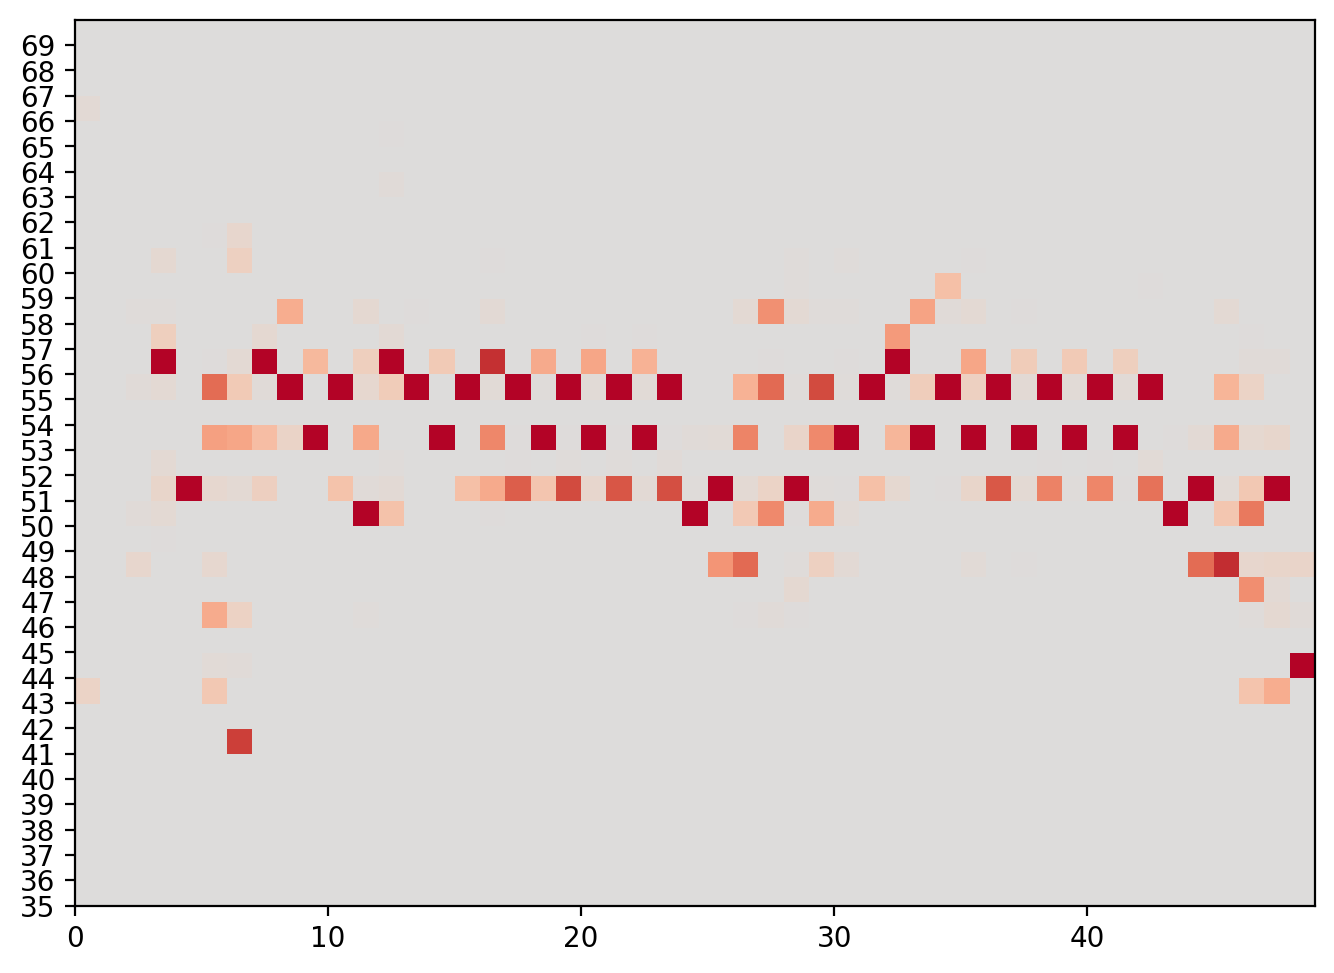

In [31]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_yticks([int(j) for j in range(35, 70)])
plt.imshow(
    grid[35:70, :],
    origin="lower",
    cmap="coolwarm",
    vmin=-0.5,
    vmax=0.5,
    extent=[0, seq_len, 35, 70],
)
plt.show()

In [32]:
plot_size = 20

att_matrix = np.zeros((plot_size, plot_size))
prediction_output = []
last_prompt = []

In [33]:
for j in range(plot_size):
    atts = info[j]["atts"].max(axis=0)
    att_matrix[: (j + 1), j] = atts
    prediction_output.append(info[j]["chosen_note"][0])
    last_prompt.append(info[j]["prompt"][0][-1])

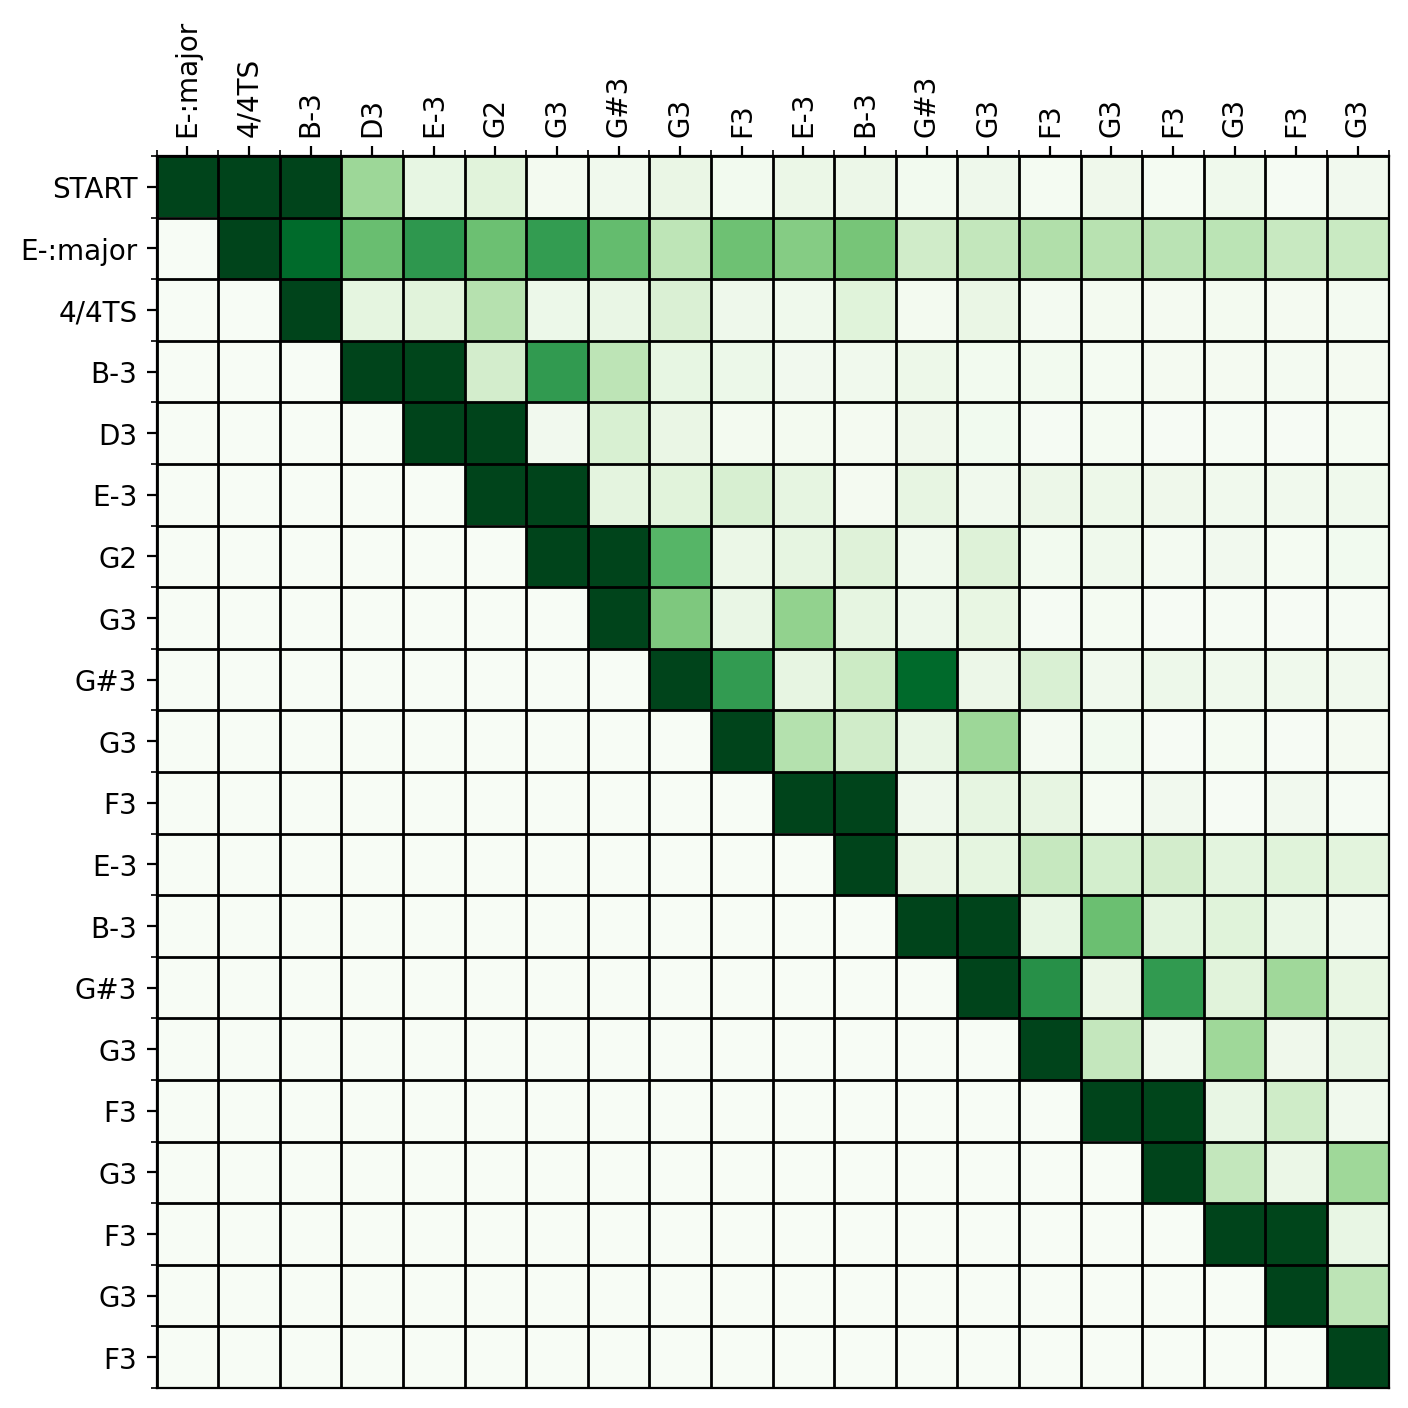

In [34]:
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(att_matrix, cmap="Greens", interpolation="nearest")

ax.set_xticks(np.arange(-0.5, plot_size, 1), minor=True)
ax.set_yticks(np.arange(-0.5, plot_size, 1), minor=True)
ax.grid(which="minor", color="black", linestyle="-", linewidth=1)
ax.set_xticks(np.arange(plot_size))
ax.set_yticks(np.arange(plot_size))
ax.set_xticklabels(prediction_output[:plot_size])
ax.set_yticklabels(last_prompt[:plot_size])
ax.xaxis.tick_top()

plt.setp(
    ax.get_xticklabels(),
    rotation=90,
    ha="left",
    va="center",
    rotation_mode="anchor",
)
plt.show()